In [41]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from keras.callbacks import *
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
# sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

# other
import time
np.random.seed(7)

In [42]:
# load training dataset
data_path = "./data/"
df_train_orig = pd.read_csv(data_path + "dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)

In [43]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)
#X:8761,X1:5869,X2:2892

In [44]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)
#X:8761,X1:5869,X2:2892

In [45]:
# Load dataset with attacks
df_test_01 = pd.read_csv(data_path + "dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv(data_path + "test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

# scale datasets
X3 = pd.DataFrame(index = df_test_01.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))
X4 = pd.DataFrame(index = df_test_02.index, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))

# get targets
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']
#Y3:valid_label,4177;Y4:test_label,2089

In [46]:
def f2_score(label, predict):
    p = precision_score(label, predict)
    r = recall_score(label, predict)
    f2_score = 5*p*r / (4*p + r)
    return f2_score

In [47]:
# assess detection
def compute_scores(Y,Yhat):
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall_score(Y,Yhat),f2_score(Y,Yhat)]

In [48]:
def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure(figsize = (10,10))
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
            # annotate主要在图形中添加注释
            # 第一个参数添加注释
            # 第二个参数是注释的内容
            # xy设置箭头尖的坐标
            # horizontalalignment水平对齐
            # verticalalignment垂直对齐
            # 其余常用参数如下:
            # xytext设置注释内容显示的起始位置
            # arrowprops 用来设置箭头
            # facecolor 设置箭头的颜色
            # headlength 箭头的头的长度
            # headwidth 箭头的宽度
            # width 箭身的宽度
    plt.ylabel('True label')  # 坐标轴标签
    plt.xlabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

In [49]:
def pred_error(preds,x):
        #preds = preds.reshape(preds.shape[0],preds.shape[1])
        #x=x.reshape(x.shape[0],x.shape[1])
        errors = (x-preds)**2
        return preds, errors

In [50]:
def detect(preds,x, theta, window = 1, average=False, sys_theta = 0):
        preds, temp = pred_error(preds,x)
        #x=x.reshape(x.shape[0],x.shape[1])
        temp = (x-preds)**2
        #temp = pd.DataFrame(temp)
        if average:
            errors = temp.mean(axis=1).rolling(window=window).mean()
            detection = errors > theta
        else:
            errors = temp.rolling(window=window).mean()
            detection = errors.apply(lambda x: x>np.max(theta.name, sys_theta))

        return detection, errors

In [51]:
adam = tf.optimizers.Adam(lr = 0.001)
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')

D:\anaconda\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [52]:
# create model  MLP
model = Sequential()
model.add(Dense(X1.shape[1], input_dim=X1.shape[1], activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(X1.shape[1], activation='tanh'))
# Compile model
model.compile(loss='mse', optimizer=adam)
# Fit the model
hist = model.fit(X1, 
          X1, 
          epochs=150, 
          batch_size=32,
          callbacks = [earlyStopping, lr_reduced],
          shuffle=True,
          validation_data=(X2,X2),
          verbose=2)

Epoch 1/150
184/184 - 1s - loss: 0.1389 - val_loss: 0.0718 - lr: 0.0010 - 520ms/epoch - 3ms/step
Epoch 2/150
184/184 - 0s - loss: 0.0650 - val_loss: 0.0552 - lr: 0.0010 - 138ms/epoch - 752us/step
Epoch 3/150
184/184 - 0s - loss: 0.0486 - val_loss: 0.0407 - lr: 0.0010 - 155ms/epoch - 845us/step
Epoch 4/150
184/184 - 0s - loss: 0.0359 - val_loss: 0.0296 - lr: 0.0010 - 161ms/epoch - 873us/step
Epoch 5/150
184/184 - 0s - loss: 0.0263 - val_loss: 0.0219 - lr: 0.0010 - 135ms/epoch - 732us/step
Epoch 6/150
184/184 - 0s - loss: 0.0200 - val_loss: 0.0168 - lr: 0.0010 - 135ms/epoch - 736us/step
Epoch 7/150
184/184 - 0s - loss: 0.0157 - val_loss: 0.0135 - lr: 0.0010 - 155ms/epoch - 842us/step
Epoch 8/150
184/184 - 0s - loss: 0.0129 - val_loss: 0.0116 - lr: 0.0010 - 141ms/epoch - 764us/step
Epoch 9/150
184/184 - 0s - loss: 0.0114 - val_loss: 0.0105 - lr: 0.0010 - 146ms/epoch - 795us/step
Epoch 10/150
184/184 - 0s - loss: 0.0105 - val_loss: 0.0099 - lr: 0.0010 - 137ms/epoch - 746us/step
Epoch 11/15

<Figure size 432x288 with 0 Axes>

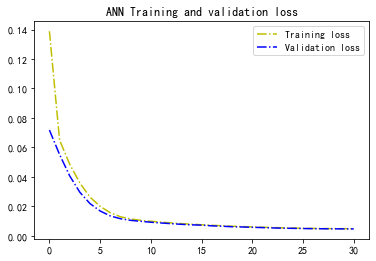

In [53]:
plt.figure()
 
#acc = hist.history['acc']
#val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
 
epochs = range(len(loss))
 
#plt.plot(epochs, acc, 'bo', label='Training acc') # 'bo'为画蓝色圆点，不连线
#plt.plot(epochs, val_acc, 'b', label='Validation acc') 
#plt.title('Training and validation accuracy')
#plt.legend() # 绘制图例，默认在右上角
 
plt.figure()
 
plt.plot(epochs, loss, 'y', label='Training loss',linestyle='-.')
plt.plot(epochs, val_loss, 'b', label='Validation loss',linestyle='-.')
plt.title('ANN Training and validation loss')
plt.legend()
 
plt.show()

In [54]:
##### 显示stacked dae重构后的效果 #####
X1_pre = model.predict(X1)
X2_pre = model.predict(X2)
X3_pre = model.predict(X3)
X4_pre = model.predict(X4)
print('X1: ',X1)
print('X1_pre: ',X1_pre)
print('X2: ',X2)
print('X2_pre: ',X2_pre)
print('X3: ',X3)
print('X3_pre: ',X3_pre)
print('X4: ',X2)
print('X4_pre: ',X4_pre)

X1:            L_T1      L_T2      L_T3      L_T4      L_T5      L_T6      L_T7  \
1170  0.488651  0.104012  0.765328  0.412776  0.353596  0.998148  0.445513   
579   0.637068  0.161366  0.928084  0.863257  0.248246  1.000000  0.942362   
2182  0.057699  0.743728  0.116650  0.597058  0.441985  1.000000  0.171913   
3608  0.732718  0.650633  0.390592  0.803850  0.849509  1.000000  0.663370   
2943  0.781443  0.942844  0.642789  0.411625  0.226870  0.191905  0.256424   
...        ...       ...       ...       ...       ...       ...       ...   
5734  0.663908  0.664919  0.067533  0.196580  0.586857  1.000000  0.517095   
5191  0.881324  0.625040  0.606332  0.622719  0.129357  0.345422  0.488734   
5390  0.904002  0.159823  0.587101  0.797103  0.615039  1.000000  0.488651   
860   0.279351  0.967521  0.414285  0.691745  0.573086  1.000000  0.846572   
7270  0.559075  0.660803  0.098045  0.392398  0.190758  1.000000  0.716468   

         F_PU1  S_PU1     F_PU2  ...    P_J300    P_J256  

0.014275580126020766


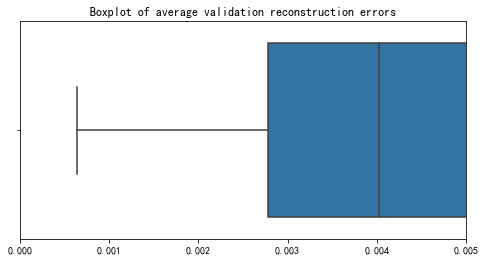

In [57]:
# perform detection

# get validation reconstruction errors
_, validation_errors = pred_error(X2_pre,X2)

# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.005])
ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta1 = validation_errors.mean(axis = 1).quantile(0.993)
theta2 = validation_errors.mean(axis = 1).quantile(0.989)
print(theta1)
Yhat3, _ = detect(X3_pre,X3, theta = 0.014 , window = 3, average=True)
Yhat4, _ = detect(X4_pre,X4, theta = 0.014, window = 3, average=True)

In [58]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall','f2_score'])
results.loc['test dataset 01'] = compute_scores(Y3,Yhat3)
results.loc['test dataset 02'] = compute_scores(Y4,Yhat4)

print('Results:\n')
print(results)

Results:

                 accuracy  f1_score precision    recall  f2_score
test dataset 01   0.93129  0.605227   0.93617  0.447154  0.499319
test dataset 02  0.867401  0.502693  0.933333   0.34398  0.393701


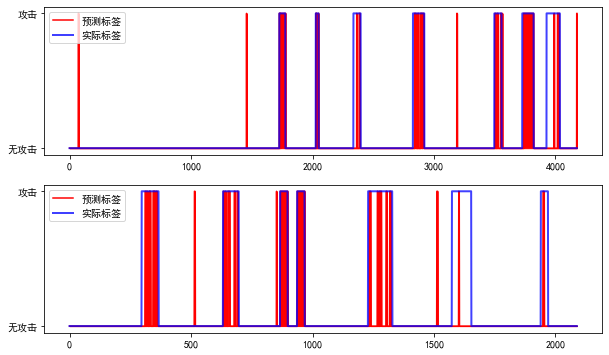

In [59]:
# plot figures
font2 = {'family' : 'SimHei',#Times New Roman
        'weight' : 'normal',
        'size'   : 10,
            }
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 6,
            }
shade_of_gray = '0.75'
f_ANN, axes = plt.subplots(2,figsize = (10,6))
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
axes[0].plot(Yhat3, color = 'r', label = '预测标签')#shade_of_gray
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color='r')
axes[0].plot(Y3, color = 'b', alpha = 0.75, lw = 2, label = '实际标签')
#axes[0].set_title('validation set', font2,loc='left')
#axes[0].set_xlabel('Time/h',font2)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['无攻击','攻击'],font2)
axes[0].legend(loc='upper left',prop=font2)
#axes[0].legend(fontsize = 8, loc = 2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

axes[1].plot(Yhat4, color = 'r', label = '预测标签')
axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color='r')
axes[1].plot(Y4, color = 'b', alpha = 0.75, lw = 2, label = '实际标签')
#axes[1].set_title('test set', font2,loc='left')
#axes[1].set_xlabel('Time/h',font2)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['无攻击','攻击'],font2)
axes[1].legend(loc='upper left',prop=font2)
#axes[1].legend(fontsize = 8, loc = 2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.savefig("f_ANN2.png", dpi=1000, bbox_inches = 'tight')

<Figure size 720x720 with 0 Axes>

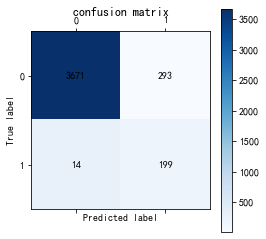

<Figure size 720x720 with 0 Axes>

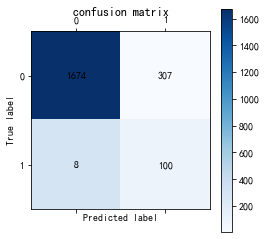

In [18]:
cm_plot(Y3,Yhat3)
cm_plot(Y4,Yhat4)